In [4]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.datasets import load_boston
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
np.random.seed(42)

/Users/nelson/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/nelson/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### GridSearch Regression Model

GridSearchCV is the modeling technique that searches for the optimal hyperparameters provided during the instantiating of the model. Using its built in cross validation it can search over the grid of the provided hyperparameters to evaluate the performance of each and then use those parameters when making the predictions on the target variable (Sale Price).

#### Variance Threshold

The variance threshold is a feature selection technique that takes in specific variance amounts and will identify all feature variables that are not meeting the threshold and remove them. This allows the model to only perform predictions on features that have a variance up to a specific amount.

#### KBest

The KBest (or SelectKBest) is a feature selection technique that allows for the selction of a specific amount of feature variables to be used when performing the predictions on the target variable (Sale Price). Specifically, using the f_regression with KBest it will score the sekected features selected use the correlation of each feature to eachother to get the optimal features. 

#### Elastic Net

Lasso regression is a regularized technique that allows the model to take on more weight related to variance. This technique is used when we have strong multicolinearity amougnst our selected feature variables. The elastic net regression imposes the lasso and ridge penalties (L1 and L2) on the estimates to those that were identified as performing the worst in the model. In this technique the elastic net will choose the optimal method (Lasso & Ridge) if one is found to be more optimal the the other.

### Step # 1: Load the Data

Loading in the cleaned kaggle test data along with the **un-scaled** training data (to be explained later) to instantiate and predict the model.

In [5]:
ames_df_test = pd.read_csv('../data/ames_iowa_data_test_data_clean', index_col='Id')
X_train_sc = pd.read_csv('../pickle/X_train_sc.csv', header=None)
X_test_sc = pd.read_csv('../pickle/X_test_sc.csv', header=None)
y_train = pd.read_csv('../data/y_train.csv', header=None)
y_test = pd.read_csv('../data/y_test.csv', header=None)
X_train = pd.read_csv('../data/X_train.csv', header=None)
X_test = pd.read_csv('../data/X_test.csv', header=None)

### Step # 2: Setup the Dummy Variables and Feature Dataframes

Recreating the same features dataframe from the train data along with creatin the features dataframe for the kaggle test data. 
- These are dataframes that contain all of our feature variables as numeric data types

In [6]:
ames_df_test_object = ames_df_test.select_dtypes(exclude=['int64', 'float64'])
ames_df_numeric_test = ames_df_test.select_dtypes(exclude='object')
ames_df_object_dummies_test = pd.get_dummies(ames_df_test_object, drop_first=True)
ames_features_test = pd.concat([ames_df_numeric_test, ames_df_object_dummies_test], axis=1)

In [7]:
ames_df = pd.read_csv('../data/ames_iowa_data_clean', index_col='Id')
ames_df_objects = ames_df.select_dtypes(exclude=['int64', 'float64'])
ames_df_numeric = ames_df.select_dtypes(exclude='object')
ames_df_object_dummies = pd.get_dummies(ames_df_objects, drop_first=True)
ames_features = pd.concat([ames_df_numeric, ames_df_object_dummies], axis=1)
ames_features.drop('saleprice', axis=1, inplace=True)

### Step # 3: Setup the Pipeline

Using a technique called Pipeline we will setup the steps that we'd like to take for feature selection. The pipe will then be used with the GridSearch to perform the actual model predictions on the target variable (Sale Price).
- Notice below we have the two feature selection options described above
    - Variance Threshold
    - KBest
- We also have the regularization regression model selected
    - Elastic Net
- Also, note that we are asking the Pipeline to perform standard scaling which is why we are going to be passing in our **un-scaled** traing data.
    - Standard Scaler

In [8]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold()),
    ('ss', StandardScaler()),
    ('kbest', SelectKBest(f_regression)),
    ('enet', ElasticNet())
])

In [9]:
params = {
    'var_thresh__threshold': [0, .05],
    'kbest__k': [30],
    'enet__alpha': np.logspace(-3, 3, 7),
    'enet__l1_ratio': [.0001, .3, .5, .7, .9, 1]
}

### Step # 4: Instantiate the GridSearch

- Identifying a variable to instantiate GridSearch 
- Analyzing the numver of features that will be taken away with the provided threshold

In [10]:
gs = GridSearchCV(pipe, params)

In [11]:
X_train.shape

(1518, 213)

In [12]:
(X_train.var() < .05).sum()

122

In [13]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x114e3f048>)), ('enet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.05], 'kbest__k': [30], 'enet__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'enet__l1_ratio': [0.0001, 0.3, 0.5, 0.7, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

### Step # 5: Fit and Score the Model

The scores below show a pretty good scoring model in my opinion. This may still be a little overfit but this model is definitely scoring much better than our Linear Regression model and it's looking almost identical to the Ridge regression GridSeach. Meaning that the optimal method selected was probably the Ridge.

In [14]:
gs.score(X_train, y_train)

0.8248067339287795

In [15]:
gs.score(X_test, y_test)

0.8658125712879559

### Step # 6: Optimal GridSearch Metrics

The next four cells will tell us what the GridSearch found to be the optimal selection for each of the follwing:
- Optimal parameters provided
- A boolean value of True for the optimal features that the variance threshold selected based on the provided parameter
- A boolean value of Treu for the optimal features that the KBest with f_regression found based off of the features that met the variance threshold
- The coefficient values for the best selected features from both the variance threshold and KBest selection using Elastic Net

In [16]:
gs.best_params_

{'enet__alpha': 0.1,
 'enet__l1_ratio': 0.0001,
 'kbest__k': 30,
 'var_thresh__threshold': 0}

In [17]:
gs.best_estimator_.named_steps['var_thresh'].get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [18]:
gs.best_estimator_.named_steps['kbest'].get_support()

array([False, False,  True,  True, False,  True,  True,  True,  True,
       False, False,  True,  True, False,  True, False, False,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [19]:
gs.best_estimator_.named_steps['enet'].coef_

array([ 5269.78965039, 18465.78016244,  2593.56022689,  5039.54200509,
        4869.55898569,  5104.62755525,  1812.66889545,  2499.67060139,
       12961.52752006,  2142.19364546,  3679.80250986,  6605.49762403,
        5590.53009443,  4294.95460004,  6474.77336434, -1023.91752041,
        1613.59476763,  1435.43021649, -6144.86543766, -7935.7778313 ,
         112.91933183,  2785.8447984 ,  1335.08831938,  6262.33465776,
        2916.11906333, -2378.82465069, -3742.83409937,   693.04264216,
       -1075.47996769,  3108.93271548])

#### Visualizing the Coefficients

Below are the coefficient values for the 60 best selected features for this model. These are what most heavily influence our model predictions.

In [20]:
columns = ames_features.columns
columns = columns[gs.best_estimator_.named_steps['var_thresh'].get_support()]
columns = columns[gs.best_estimator_.named_steps['kbest'].get_support()]

pd.DataFrame(gs.best_estimator_.named_steps['enet'].coef_, 
             index = columns, columns=['Coef Weights'])

,Coef Weights
lot_area,5269.789650
overall_qual,18465.780162
year_built,2593.560227
year_remod/add,5039.542005
mas_vnr_area,4869.558986
bsmtfin_sf_1,5104.627555
total_bsmt_sf,1812.668895
1st_flr_sf,2499.670601
gr_liv_area,12961.527520
full_bath,2142.193645


### Step # 7: Predict the Model

Using the trained scaled testing data predict the target variable (Sale Price).

In [21]:
pred_gs = gs.predict(X_test)

In [22]:
np.sqrt(mean_squared_error(y_test, pred_gs)) ## RMSE (Kaggle RMSE: 40071.83370)

29811.058588786407

In [23]:
pred_gs.shape

(507,)

In [24]:
y_test.shape

(507, 1)

Text(0,0.5,'Actual Values')

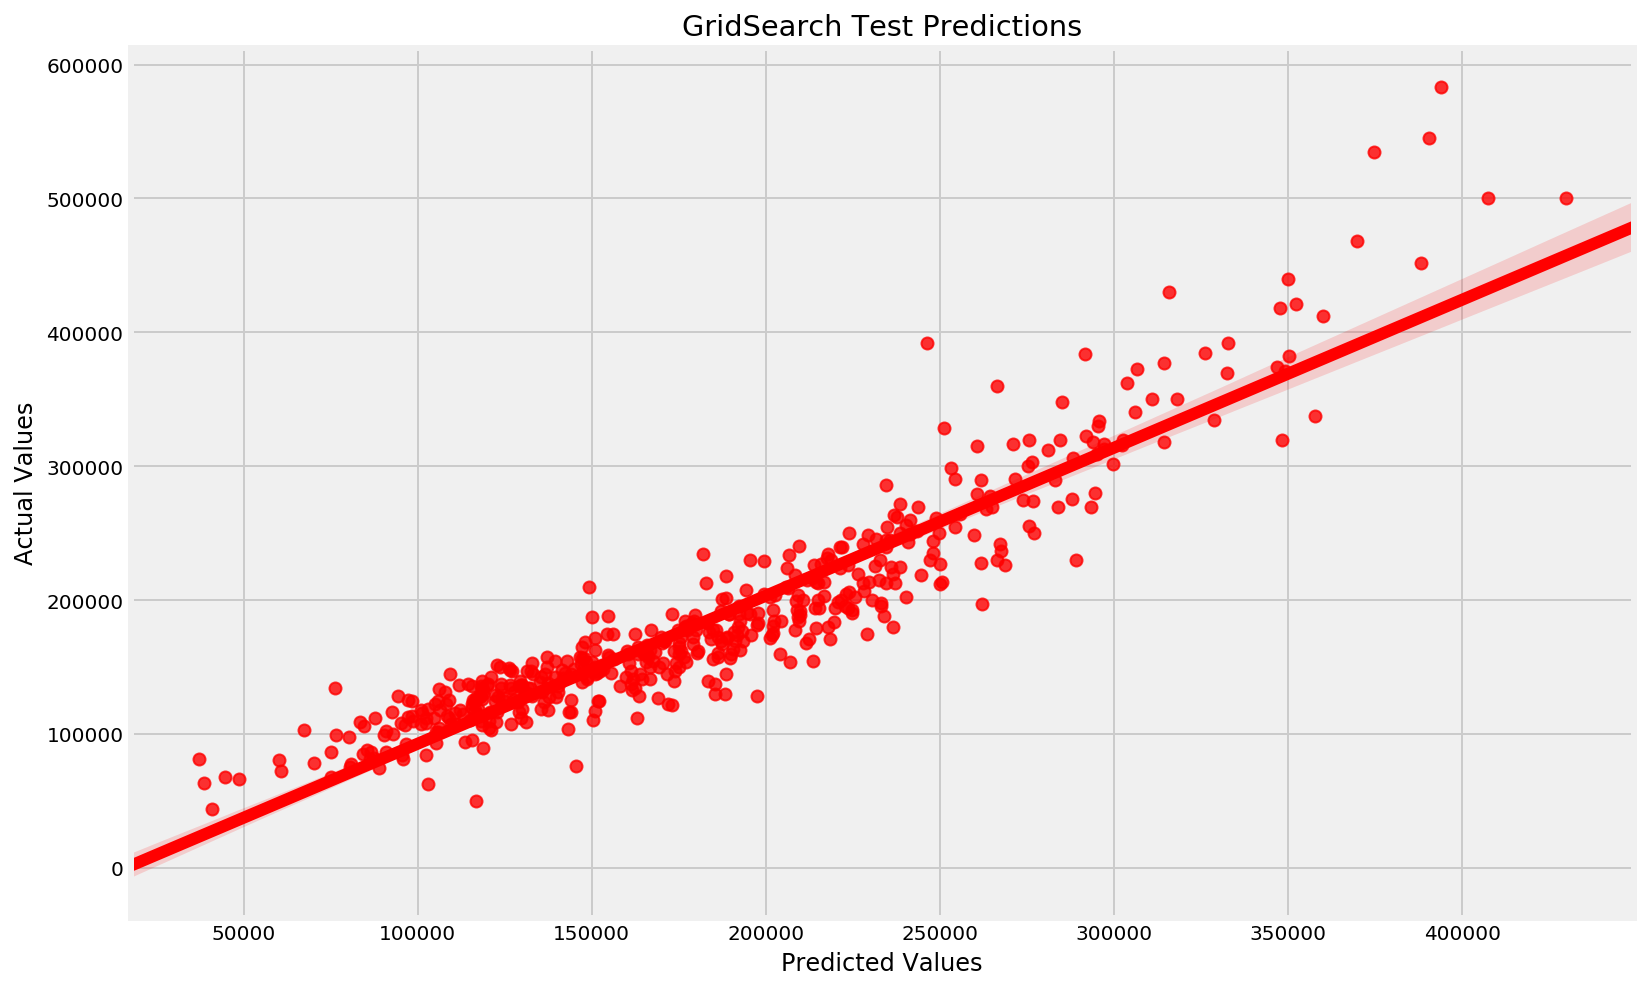

In [25]:
plt.figure(figsize=(12,8))
sns.regplot(pred_gs, y_test[0] , color='red')
plt.title("GridSearch Test Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

#### Interpretation

A much better looking model prediction than the Linear Regression model and very similar to the GridSearch with Ridge model. The visual shows a bit of overfitting but defintely can be argued as a very well predicted line. We can interpret the Root Mean Squared Error metric of this model as basically saying that we believe on average our scores to be between +/- 28205.70803433927 which is good but the other model did perform a bit better if you base it off this RMSE metric and there is still room for improvement.

### GridSearch Kaggle Predictions

The below is my submission to the Kaggle competition for this GridSearch model

In [26]:
diff_cols = set(ames_features.columns).difference(ames_features_test.columns)

In [27]:
for col in diff_cols:
    ames_features_test[col]=0

In [28]:
kaggle = ames_features_test[ames_features.columns]

In [29]:
pred_gs_final = gs.predict(kaggle)

In [30]:
final_gs_df = pd.DataFrame(pred_gs_final, index=kaggle.index, columns=['saleprice'])

In [31]:
final_gs_df.sort_index(inplace=True)

In [33]:
## original enet_predictions2

In [34]:
final_gs_df.to_csv('../data/gs_enet_predictions10')

#### Kaggle Score RMSE: 40071.83370